In [1]:
using Arrhenius
using ForwardDiff
using LinearAlgebra
using DiffEqSensitivity
using DifferentialEquations

using Random
using ProgressBars
using DelimitedFiles
using Plots, Colors, Printf, Profile
Threads.nthreads() = 8;

## 1. Validation of Pyrolysis Simulation 

### 1.1 Load Cantera results

In [2]:
cantera_data = readdlm("pyrolysis.dat");
ct_t = cantera_data[:, 1];
ct_T = cantera_data[:, 2];
ct_Y = cantera_data[:, 3:end];
ct_u = hcat(ct_Y, ct_T)';

### 1.2 Simulate in `Arrhenius.jl`

In [3]:
gas = CreateSolution("../../mechanism/JP10skeletal.yaml");
ns = gas.n_species;
nr = gas.n_reactions;
gas.species_names;

Y0 = zeros(ns);
Y0[species_index(gas, "C10H16")] = 0.05;
Y0[species_index(gas, "N2")] = 0.95;
T0 = 1200.0;
P = one_atm;
u0 = vcat(Y0, T0);

@inbounds function dudt!(du, u, p, t)
    T = u[end]
    Y = @view(u[1:ns])
    
    mean_MW = 1. / dot(Y, 1 ./ gas.MW)
    ρ_mass = P / R / T * mean_MW
    X = Y2X(gas, Y, mean_MW)
    C = Y2C(gas, Y, ρ_mass)
    cp_mole, cp_mass = get_cp(gas, T, X, mean_MW)
    h_mole = get_H(gas, T, Y, X)
    S0 = get_S(gas, T, P, X)
    
    wdot = wdot_func(gas.reaction, T, C, S0, h_mole)
    
    Ydot = wdot / ρ_mass .* gas.MW
    Tdot = -dot(h_mole, wdot) / ρ_mass / cp_mass
    du .= vcat(Ydot, Tdot)
end

# reltol=1e-3
# abstol=1e-6

# reltol=1e-6
# abstol=1e-9

reltol=1e-9
abstol=1e-12

tspan = [0.0, ct_t[end]*1.001];
prob = ODEProblem(dudt!, u0, tspan);
sol = solve(prob, TRBDF2(), reltol=reltol, abstol=abstol, saveat=ct_t);
ar_t = sol.t;
ar_u = Array(sol);

### 1.3 Validation

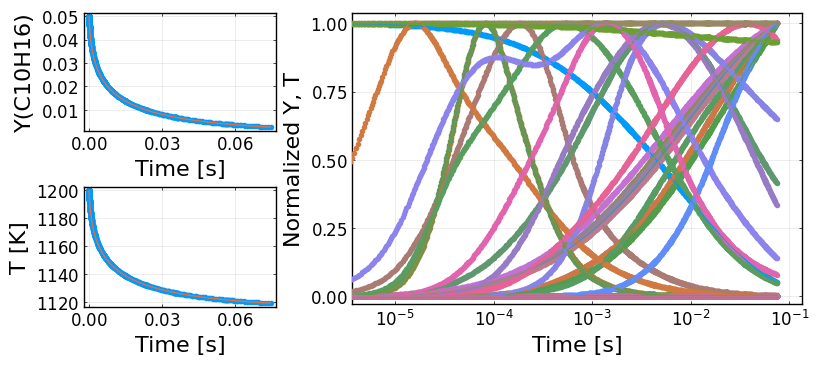

In [4]:
using PyPlot
using Plots: plot, grid

Plots.pyplot()
Plots.resetfontsizes()
Plots.scalefontsizes(1.5)
function valid(t, y_true, y_pred, xscale)
    IJulia.clear_output(true)
    
    h1 = plot(legend=false)
    plot!(t, y_true[species_index(gas, "C10H16"),:], line=(1,:scatter), msw=0, label="Groundtruth")
    plot!(t, y_pred[species_index(gas, "C10H16"),:], line=(1,:solid), label="Prediction")
    xticks!([0.0, 0.03, 0.06, 0.09])
    ylabel!(h1, "Y(C10H16)")
    xlabel!(h1, "Time [s]")
    
    h2 = plot(legend=false)
    plot!(t, y_true[end,:], line=(1,:scatter), msw=0, label="Groundtruth")
    plot!(t, y_pred[end,:], line=(1,:solid), label="Prediction")
    xticks!([0.0, 0.03, 0.06, 0.09])
    ylabel!(h2, "T [K]")
    xlabel!(h2, "Time [s]")
    
    xlim = [5e-6, 1e-1];
    scale = maximum(abs.(y_true), dims=2)
    scale = max.(scale, 1e-16)
    h3 = plot(palette=palette(:default, length(scale)), xscale=xscale,
            xlim=xlim, legend=false)
    plot!(t[2:end], (y_true[:,2:end]./scale)', line=(1, :scatter), msw=0)
    plot!(t[2:end], (y_pred[:,2:end]./scale)', line=(1, :solid))
    ylabel!(h3, "Normalized Y, T")
    xlabel!(h3, "Time [s]")
    
    h = plot(h1, h2, h3, layout=@layout[grid(2,1) a{0.7w}], size=(800,350), framestyle=:box, fg_legend=:transparent)
    # display(h)
    sleep(1e-9)
    return h;
end
h = valid(ct_t, ct_u, ar_u, :log10)
Plots.savefig(h, "figures/JP10sk_validation.svg")

## 2. Optimization

In [5]:
using Flux
using Flux: crossentropy
using Flux.Losses: mae, mse
using Flux.Optimise: update!
using LatinHypercubeSampling
using Statistics

In [6]:
# settings
solver = TRBDF2();

datasize = 50;
tsteps = 10 .^ range(log10(1e-8), log10(1e-1), length=datasize);
tspan = [0.0, tsteps[end]*1.001];

rng = MersenneTwister(0x7777777);
p_true = zeros(nr);
p_pred = 1.0*(2*rand(rng, nr).-1);
p_init = deepcopy(p_pred);

grad_max = 10 ^ (1);

### 2.1 Test for gradient computation

In [7]:
# ODE function
@inbounds function dudtp!(du, u, p, t)
    T = u[end]
    Y = @view(u[1:ns])
    
    mean_MW = 1. / dot(Y, 1 ./ gas.MW)
    ρ_mass = P / R / T * mean_MW
    X = Y2X(gas, Y, mean_MW)
    C = Y2C(gas, Y, ρ_mass)
    cp_mole, cp_mass = get_cp(gas, T, X, mean_MW)
    h_mole = get_H(gas, T, Y, X)
    S0 = get_S(gas, T, P, X)
    
    qdot = wdot_func(gas.reaction, T, C, S0, h_mole, get_qdot = true)
    wdot = gas.reaction.vk * (qdot .* exp.(p))
    
    Ydot = wdot / ρ_mass .* gas.MW
    Tdot = -dot(h_mole, wdot) / ρ_mass / cp_mass
    du .= vcat(Ydot, Tdot)
end

dudtp! (generic function with 1 method)

In [8]:
prob = ODEProblem(dudtp!, u0, tspan);

function fsol(p)
    sol = solve(prob, u0=u0, solver, p=p, tspan=tspan, saveat=tsteps,
                reltol=1e-3, abstol=1e-6, sensealg=sensealg)
    return sol[end, end]
end

# sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP(false))
# sensealg = BacksolveAdjoint(autojacvec=ReverseDiffVJP(false))
sensealg = ForwardDiffSensitivity()
# sensealg = ForwardSensitivity(autojacvec=true)

# solver = Rosenbrock23()
solver = TRBDF2()

println("timing ode solver ...")
@time fsol(p_true)
@time fsol(p_true)
@time ForwardDiff.gradient(fsol, p_true)
@time grad_nominal = ForwardDiff.gradient(fsol, p_true)'

timing ode solver ...
  9.822749 seconds (24.37 M allocations: 1.448 GiB, 5.32% gc time)
  0.015629 seconds (27.25 k allocations: 15.915 MiB)
 40.264711 seconds (84.66 M allocations: 7.704 GiB, 5.09% gc time)
  1.931143 seconds (941.09 k allocations: 4.194 GiB, 13.73% gc time)


1×232 Adjoint{Float64,Array{Float64,1}}:
 -4.57061  0.785758  0.0232836  …  2.24718e-30  4.14211e-7  -0.293975

### 2.2 Generate Datasets

In [9]:
n_exp_train = 20;
n_exp_valid = 5;
n_exp = n_exp_train + n_exp_valid;

noise = 0;
abstol = 1e-9;
reltol = 1e-12;

ns = gas.n_species;

rng = MersenneTwister(0x7777777);

u0_list = zeros(Float64, (n_exp, ns+1));
randvals = randomLHC(rng, n_exp, 2) ./ n_exp;
for i in range(1, length=n_exp)
    Y0 = zeros(ns);
    if i <= n_exp_train
        T0 = 1000 + 200*randvals[i,1]; # 1000-1200K
        val = 0.02 + 0.18*randvals[i,2]; # Y[JP10] = 0.02-0.2
    else
        T0 = 1200 + 200*randvals[i,1]; # 1200-1400K
        val = 0.2 + 0.1*randvals[i,2]; # Y[JP10] = 0.2-0.3
    end
    Y0[species_index(gas, "C10H16")] = val;
    Y0[species_index(gas, "N2")] = 1 - val;
    u0 = vcat(Y0, T0);
    u0_list[i,:] = u0;
end
P = one_atm;

datasize = 10;
tsteps = 10 .^ range(log10(1e-6), log10(1e-1), length=datasize);

datadense = 100;
tdense = 10 .^ range(log10(1e-6), log10(1e-1), length=datadense);

tspan = [0.0, tsteps[end]*1.001];

# train_idx = [
#     species_index(gas, "C2H4"),
#     species_index(gas, "CH4"),
# ]

# 5opt
# train_idx = [
#     species_index(gas, "C10H16"),
#     species_index(gas, "C2H4"),
#     species_index(gas, "C5H6"),
#     species_index(gas, "CH4"),
#     ns+1 # Temperature
# ]

# # 11opt
# train_idx = [
#     species_index(gas, "C10H16"),
#     species_index(gas, "H2"),
#     species_index(gas, "C2H4"),
#     species_index(gas, "C5H6"),
#     species_index(gas, "CO"),
#     species_index(gas, "C6H6"),
#     species_index(gas, "CH4"),
#     species_index(gas, "C2H2"),
#     species_index(gas, "C3H6"),
#     species_index(gas, "C6H5CH3"),
#     ns+1 # Temperature
# ]

train_idx = 1:(ns+1);

y_true_list = zeros(Float64, (n_exp, ns+1, datasize));
y_init_list = zeros(Float64, (n_exp, ns+1, datadense));
yscale_list = [];

max_min(y) = maximum(y, dims=2) .- minimum(y, dims=2);
for i = 1:n_exp
    u0 = u0_list[i, :]
    _prob = ODEProblem(dudtp!, u0, tspan, p_true)
    y_true = Array(solve(_prob, solver, saveat=tsteps, abstol=abstol, reltol=reltol))
    y_true += noise * randn(size(y_true)) .* y_true
    y_true_list[i, :, :] = y_true
    push!(yscale_list, max_min(y_true))
end

for i = 1:n_exp
    u0 = u0_list[i, :]
    _prob = ODEProblem(dudtp!, u0, tspan, p_init)
    y_init = Array(solve(_prob, solver, saveat=tdense, abstol=abstol, reltol=reltol))
    y_init_list[i, :, :] = y_init
end

In [10]:
yscale_raw = maximum(abs.(hcat(yscale_list...)), dims=2);
yscale = max.(yscale_raw, 1e-16);
# show(stdout, "text/plain", yscale');

In [11]:
function valid(t, y_true, tdense, y_pred, xscale)
    IJulia.clear_output(true)
    
    h1 = plot(legend=false)
    plot!(t, y_true[species_index(gas, "C10H16"),:], line=(1,:scatter), msw=0, label="Groundtruth")
    plot!(tdense, y_pred[species_index(gas, "C10H16"),:], line=(1,:solid), label="Prediction")
    xticks!([0.0, 0.03, 0.06, 0.09])
    ylabel!(h1, "Y(C10H16)")
    xlabel!(h1, "Time [s]")
    
    h2 = plot(legend=false)
    plot!(t, y_true[end,:], line=(1,:scatter), msw=0, label="Groundtruth")
    plot!(tdense, y_pred[end,:], line=(1,:solid), label="Prediction")
    xticks!([0.0, 0.03, 0.06, 0.09])
    ylabel!(h2, "T [K]")
    xlabel!(h2, "Time [s]")
    
    xlim = [5e-6, 1e-1];
    scale = maximum(abs.(y_true), dims=2)
    scale = max.(scale, 1e-16)
    h3 = plot(palette=palette(:default, length(scale)), xscale=xscale,
            xlim=xlim, legend=false)
    plot!(t[2:end], (y_true[:,2:end]./scale)', line=(1, :scatter), msw=0)
    plot!(tdense[2:end], (y_pred[:,2:end]./scale)', line=(1, :solid))
    ylabel!(h3, "Normalized Y, T")
    xlabel!(h3, "Time [s]")
    
    h = plot(h1, h2, h3, layout=@layout[grid(2,1) a{0.7w}], size=(800,350), framestyle=:box, fg_legend=:transparent)
    # display(h)
    sleep(1e-9)
    return h;
end

valid (generic function with 2 methods)

### 2.3 Compare wrong initial `y_init`

#### Case 1: First training set

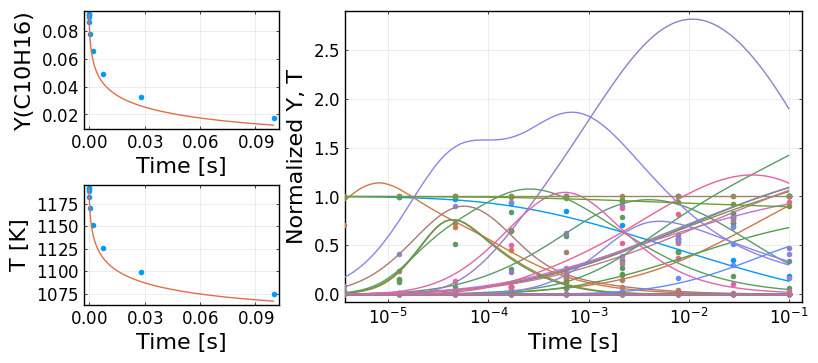

In [12]:
y_true = y_true_list[1,:,:]
y_init = y_init_list[1,:,:]
h = valid(tsteps, y_true, tdense, y_init, :log10)
Plots.savefig(h, "figures/JP10sk_initial_train_1.svg")

#### Case 2: First validation set

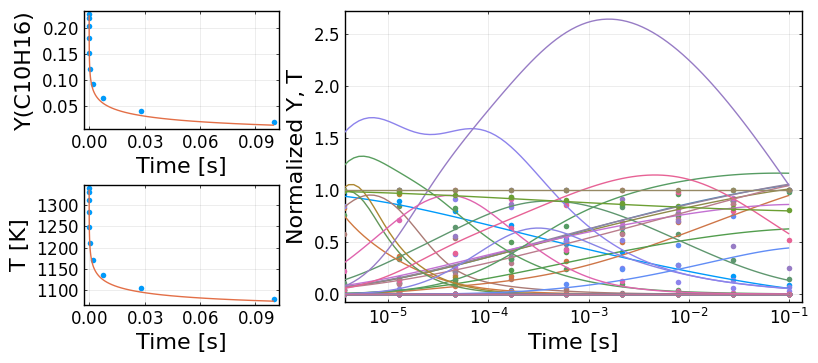

In [13]:
y_true = y_true_list[n_exp_train+5,:,:]
y_init = y_init_list[n_exp_train+5,:,:]
h = valid(tsteps, y_true, tdense, y_init, :log10)
Plots.savefig(h, "figures/JP10sk_initial_valid_1.svg")

In [14]:
# Regularization of parameters
vecnorm(x) = sum(abs2,x)
vecnorm(p_init-p_true)

74.30739040022686

In [15]:
sensealg = ForwardDiffSensitivity()
function predict_ode(u0, p; sample = datasize)
    _prob = remake(prob, u0=u0, p=p, tspan=[0, tsteps[sample]])
    sol = solve(_prob, solver, saveat=tsteps[1:sample], sensalg=sensealg,
                reltol=reltol, abstol=abstol, verbose=false)
    pred = Array(sol)
    if sol.retcode == :Success
        nothing
    else
        println("ode solver failed")
    end
    return pred
end

function loss_ode(p, i_exp; abstol=1e-12, sample = datasize)
    y_pred = predict_ode(u0_list[i_exp,:], p; sample)[train_idx,:]
    y_true = y_true_list[i_exp,train_idx,1:sample]
    yscale = max.(yscale_list[i_exp], abstol)[train_idx];
    loss = mse(y_true./yscale, y_pred./yscale) + vecnorm(p-p_init)*1e-4
    return loss
end

loss_ode(p_init, 1)

0.03880720341274495

In [16]:
loss_ode(p_init, n_exp_train+1; abstol=1e-9)

0.04194749889344761

### 2.4 Training by Datasets

In [17]:
losses_y_train = Vector{Float64}();
losses_y_valid = Vector{Float64}();
losses_p = Vector{Float64}();
history_p_pred = Vector{Array{Float64}}();

# save losses
loss_epoch = zeros(Float64, n_exp);
for i_exp in 1:n_exp
    loss_epoch[i_exp] = loss_ode(p_pred, i_exp; abstol=abstol)
end
loss_y_train = mean(loss_epoch[1:n_exp_train]);
loss_y_valid = mean(loss_epoch[n_exp_train+1:end]);
loss_p = mae(p_pred, p_true)
push!(losses_y_train, loss_y_train)
push!(losses_y_valid, loss_y_valid)
push!(losses_p, loss_p)
push!(history_p_pred, p_init);

In [18]:
function train(opt; n_epoch=10, batchsize=50, reltol=1e-6, abstol=1e-9)
    epochs = ProgressBar(1:n_epoch);
    loss_epoch = zeros(Float64, n_exp);
    grad_norm = zeros(Float64, n_exp_train);
    for epoch in epochs
        # update parameters
        global p_pred
        for i_exp in randperm(n_exp_train)
            sample = rand(batchsize:datasize)
            grad = ForwardDiff.gradient(
                        x -> loss_ode(x, i_exp; abstol=abstol, sample),
                        p_pred)
            grad_norm[i_exp] = norm(grad, 2)
            if grad_norm[i_exp] > grad_max
                grad = grad ./ grad_norm[i_exp] .* grad_max
            end
            update!(opt, p_pred, grad)
        end

        # save losses
        for i_exp in 1:n_exp
            loss_epoch[i_exp] = loss_ode(p_pred, i_exp; abstol=abstol)
        end
        loss_y_train = mean(loss_epoch[1:n_exp_train]);
        loss_y_valid = mean(loss_epoch[n_exp_train+1:end]);
        loss_p = mae(p_pred, p_true)
        push!(history_p_pred, deepcopy(p_pred))
        push!(losses_y_train, loss_y_train)
        push!(losses_y_valid, loss_y_valid)
        push!(losses_p, loss_p)
        
        # show results
        if epoch%5==0
            u0 = u0_list[n_exp_train+1,:]
            _prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
            y_pred = Array(solve(_prob, solver, saveat=tdense, sensalg=sensealg,
                        reltol=reltol, abstol=abstol, verbose=false))
            valid(tsteps, y_true_list[n_exp_train+1,:,:], tdense, y_pred, :log10)
        end
        set_description(epochs, string(@sprintf("Loss ytrain %.3e yvalid %.3e p %.3e gnorm %.3e",
                    loss_y_train, loss_y_valid, loss_p, mean(grad_norm))))
    end
end

train (generic function with 1 method)

In [19]:
opt = ADAMW(0.05, (0.9, 0.999), 1.f-6);
train(opt; n_epoch=10, batchsize=5, reltol=1e-6, abstol=1e-9)

Loss ytrain 5.456e-04 yvalid 1.293e-03 p 4.665e-01 gnorm 8.952e-04 100.0%┣┫ 10/10 [10:14<00:00, 68s/it]
Loss ytrain 5.456e-04 yvalid 1.293e-03 p 4.665e-01 gnorm 8.952e-04 100.0%┣┫ 10/10 [10:14<00:00, 68s/it]


In [20]:
opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt; n_epoch=40, batchsize=10, reltol=1e-6, abstol=1e-9)

Loss ytrain 4.295e-04 yvalid 7.366e-04 p 4.637e-01 gnorm 8.091e-04 100.0%┣┫ 40/40 [01:22:57<00:00, 128s/it]
Loss ytrain 4.295e-04 yvalid 7.366e-04 p 4.637e-01 gnorm 8.091e-04 100.0%┣┫ 40/40 [01:22:57<00:00, 128s/it]


In [21]:
opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
train(opt; n_epoch=50, batchsize=10, reltol=1e-9, abstol=1e-12)

Loss ytrain 4.477e-04 yvalid 7.100e-04 p 4.622e-01 gnorm 8.468e-04 100.0%┣┫ 50/50 [01:43:29<00:00, 127s/it]
Loss ytrain 4.477e-04 yvalid 7.100e-04 p 4.622e-01 gnorm 8.468e-04 100.0%┣┫ 50/50 [01:43:29<00:00, 127s/it]


In [22]:
# opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
# train(opt; n_epoch=100, batchsize=10, reltol=1e-9, abstol=1e-12)

In [23]:
# train(opt; n_epoch=100, batchsize=100, reltol=1e-9, abstol=1e-12)

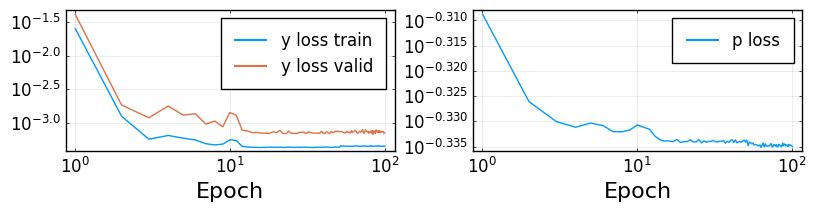

In [24]:
h1 = plot(yscale=:log10, xscale=:log10)
plot!(losses_y_train, lc=1, label="y loss train")
plot!(losses_y_valid, lc=2, label="y loss valid")
xlabel!("Epoch")
xticks!([1, 10, 100])

h2 = plot(yscale=:log10, xscale=:log10)
plot!(losses_p, lc=1, label="p loss")
xlabel!("Epoch")
xticks!([1, 10, 100])

h = plot(h1, h2, legend=true, size=(800,200), framestyle=:box)
Plots.savefig(h, "figures/JP10sk_losses.svg")

In [25]:
# function valid_p(p_init, p_pred)
#     plot(size=(800,200))
#     plot!(p_init, line=(3,:dot), label="p_init", linecolor=1)
#     plot!(p_pred, line=(3,:dot), label="p_pred", linecolor=2)
# end
# valid_p(p_init, p_pred)

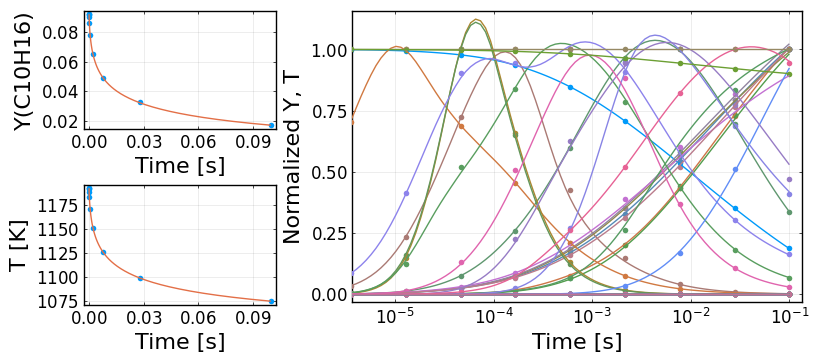

In [26]:
reltol = 1e-9;
abstol = 1e-12;
i_exp = 1
u0 = u0_list[i_exp,:]
y_true = y_true_list[i_exp,:,:]
_prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
y_pred = solve(_prob, solver, saveat=tdense, sensalg=sensealg,
            reltol=reltol, abstol=abstol, verbose=false)
h = valid(tsteps, y_true, tdense, y_pred, :log10)
Plots.savefig(h, "figures/JP10sk_trained_train_1.svg")

In [27]:
# valid(tsteps, y_true, y_pred, :linear)

In [28]:
# @show [loss_ode(p_pred, i) for i in 1:25];
# vecnorm(p_init-p_pred)

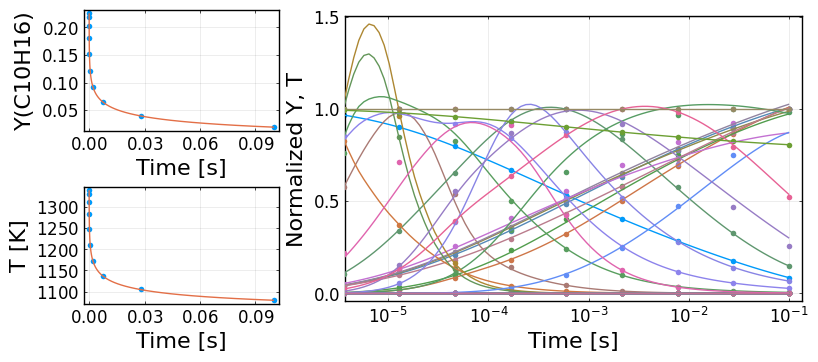

In [29]:
i_exp = n_exp_train + 5
u0 = u0_list[i_exp,:]
y_true = y_true_list[i_exp,:,:]
_prob = remake(prob, u0=u0, p=p_pred, tspan=tspan)
y_pred = solve(_prob, solver, saveat=tdense, sensalg=sensealg,
            reltol=reltol, abstol=abstol, verbose=false)
h = valid(tsteps, y_true, tdense, y_pred, :log10)
Plots.savefig(h, "figures/JP10sk_trained_valid_1.svg")

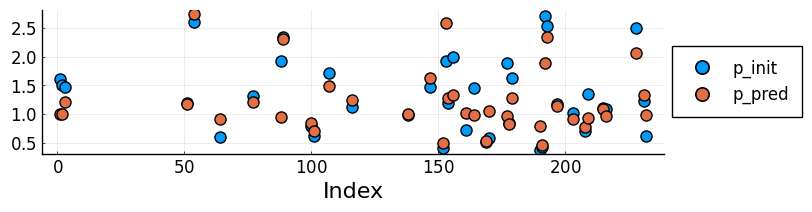

In [30]:
p_indexs = Vector{Int64}();
p_change = Vector{Float64}();
plot(p_pred - p_init)
for i in 1:nr
    if abs(p_pred[i] - p_init[i]) > 0.01
        push!(p_indexs, i)
    end
end
using Plots: scatter
h = plot(legend=:outerright, size=(800,200))
scatter!(p_indexs, exp.(p_init[p_indexs]),markersize=8, label="p_init")
scatter!(p_indexs, exp.(p_pred[p_indexs]),markersize=8, label="p_pred")
xlabel!("Index")
Plots.savefig(h, "figures/JP10sk_p_update.svg")

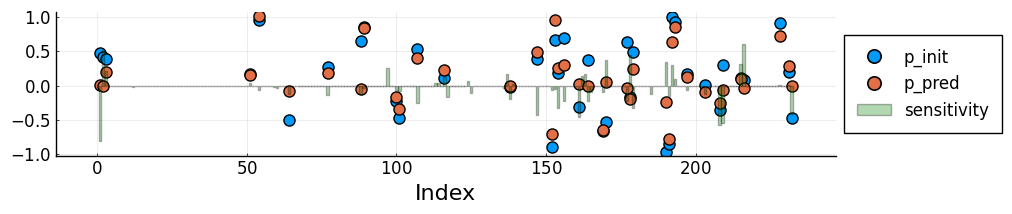

In [31]:
using Plots: scatter
grad = sqrt.(sqrt.(abs.(grad_nominal))).* sign.(grad_nominal)
sens = grad / norm(grad) * 2
h = plot(legend=:outerright, size=(1000,200))
scatter!(p_indexs, (p_init[p_indexs]), markersize=8, label="p_init")
scatter!(p_indexs, (p_pred[p_indexs]), markersize=8, label="p_pred")
Plots.bar!(1:232, sens', color=:green, mse=0., alpha = 0.3, label="sensitivity")
xlabel!("Index")
Plots.savefig(h, "figures/JP10sk_p_update_sens.svg")

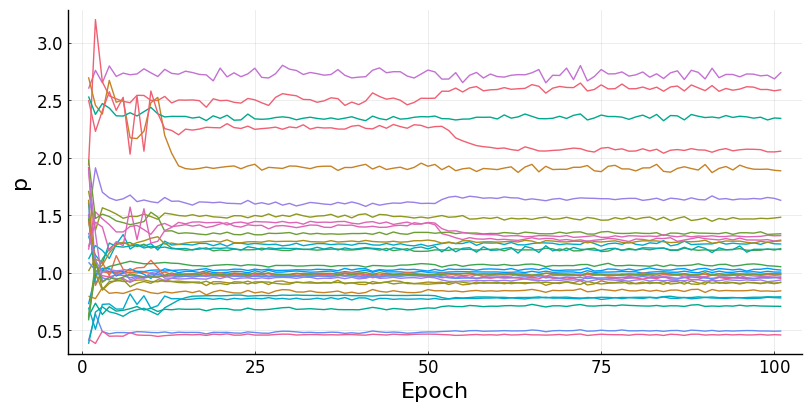

In [32]:
history_p = hcat(history_p_pred...)'
h = plot(size=(800,400))
for i in 1:nr
    if abs(p_pred[i] - p_init[i]) > 0.05
        plot!(exp.(history_p[:,i]), label="")
    end
end
xlabel!("Epoch")
ylabel!("p")
Plots.savefig(h, "figures/history_p.svg")

In [33]:
# plot(hisotry_p')

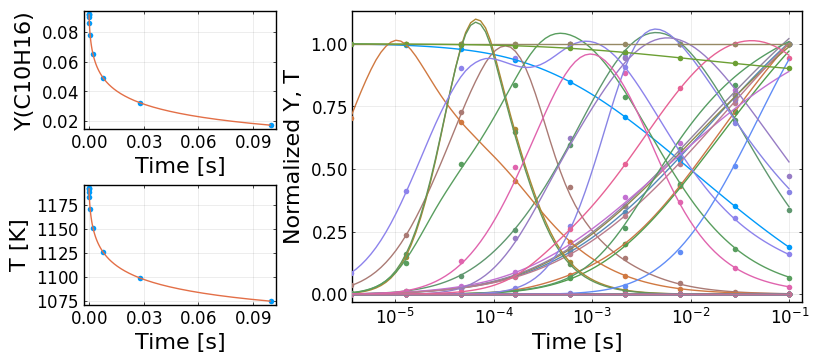

In [34]:
i_exp = 1
i_epoch = 50
u0 = u0_list[i_exp,:]
y_true = y_true_list[i_exp,:,:]
_prob = remake(prob, u0=u0, p=history_p[i_epoch,:], tspan=tspan)
y_pred = solve(_prob, solver, saveat=tdense, sensalg=sensealg,
            reltol=reltol, abstol=abstol, verbose=false)
h = valid(tsteps, y_true, tdense, y_pred, :log10)
Plots.savefig(h, "figures/JP10sk_epoch=50_train_1.svg")

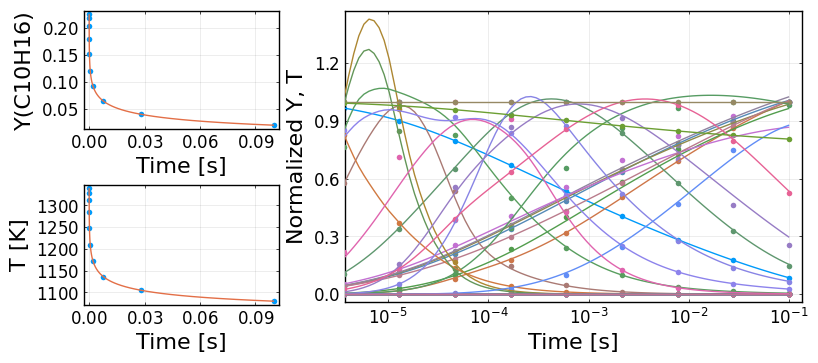

In [35]:
i_exp = n_exp_train + 5
i_epoch = 50
u0 = u0_list[i_exp,:]
y_true = y_true_list[i_exp,:,:]
_prob = remake(prob, u0=u0, p=history_p[i_epoch,:], tspan=tspan)
y_pred = solve(_prob, solver, saveat=tdense, sensalg=sensealg,
            reltol=reltol, abstol=abstol, verbose=false)
h = valid(tsteps, y_true, tdense, y_pred, :log10)
Plots.savefig(h, "figures/JP10sk_epoch=50_valid_1.svg")

In [36]:
grad_nominal

1×232 Adjoint{Float64,Array{Float64,1}}:
 -4.57061  0.785758  0.0232836  …  2.24718e-30  4.14211e-7  -0.293975

In [37]:
@show u0_list[1,  species_index(gas, "C10H16")], u0_list[1,  end]
@show u0_list[25, species_index(gas, "C10H16")], u0_list[25, end]

(u0_list[1, species_index(gas, "C10H16")], u0_list[1, end]) = (0.092, 1192.0)
(u0_list[25, species_index(gas, "C10H16")], u0_list[25, end]) = (0.228, 1344.0)


(0.228, 1344.0)

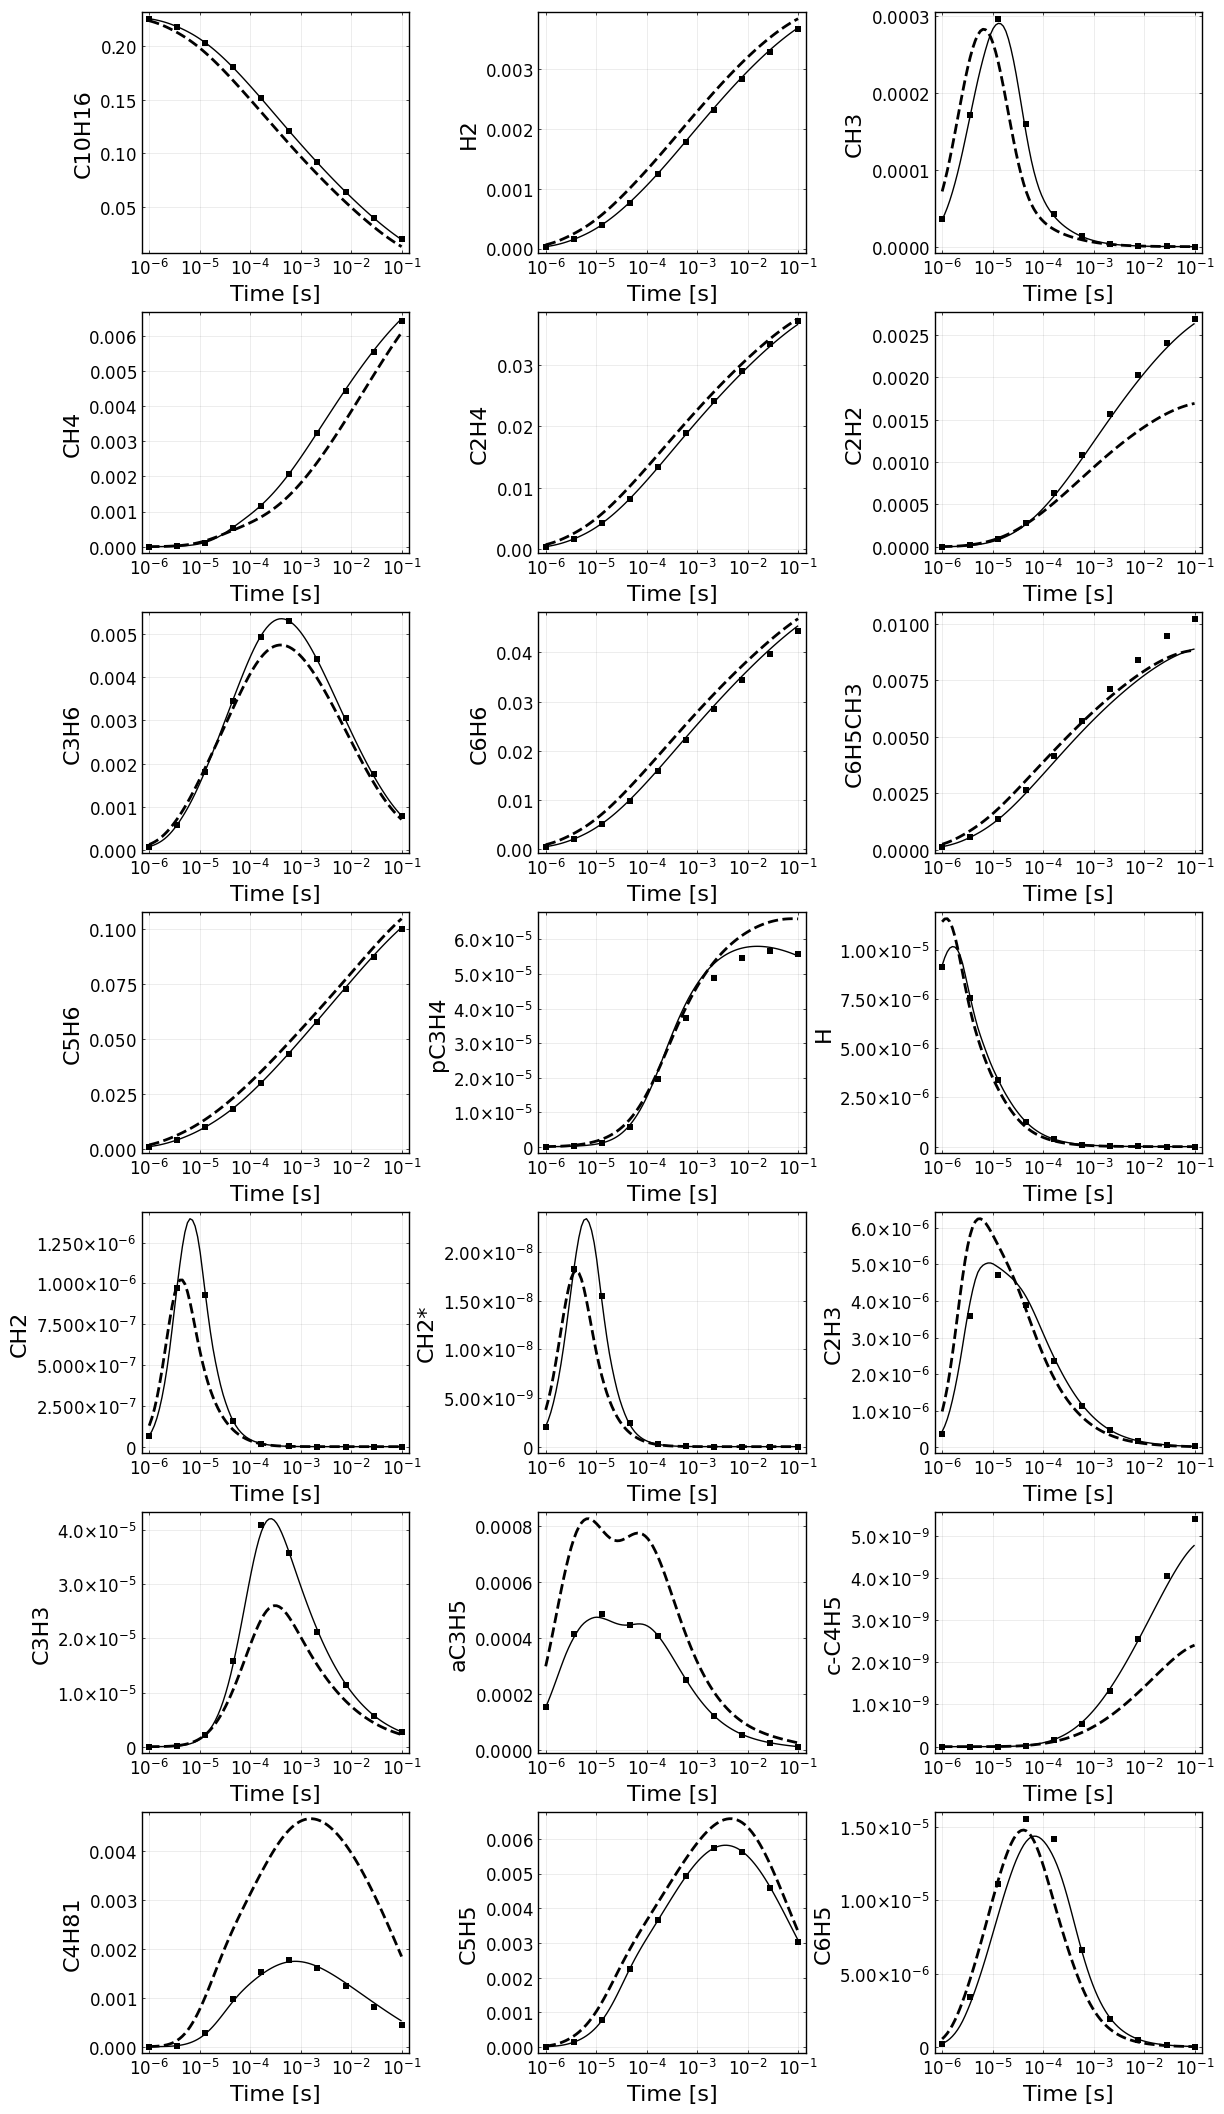

In [38]:
minmax(x) = maximum(abs.(x)) - minimum(abs.(x));
function plot_all_species(t, y_true, tdense, y_init, y_pred, xscale)
    IJulia.clear_output(true)
    
    plt_arr = []
    xlim = [5e-6, 1e-1];
    for (i,sp) in enumerate(gas.species_names)
        h1 = plot(legend=false, # formatter=:scientific, # size=(200,100),
              framestyle=:box, fg_legend=:transparent, xscale=xscale)
        plot!(t, y_true[species_index(gas, sp), :], color=:black, line=(1,:scatter), markershape=:square, msw=0)
        plot!(tdense, y_init[species_index(gas, sp), :], color=:black, line=(2,:dash), msw=0)
        plot!(tdense, y_pred[species_index(gas, sp), :], color=:black, line=(1,:solid), msw=0)
        # xticks!([])
        # yticks!([])
        ylabel!(h1, sp)
        xlabel!(h1, "Time [s]")
        
        val = y_true[species_index(gas, sp), :]
        if (maximum(val) > 1e-16 && minmax(val) > 1e-16)
            push!(plt_arr, h1)
        end
    end
    h = plot(plt_arr..., layout=(7,3), size=(1200,2100), framestyle=:box, fg_legend=:transparent)
    sleep(1e-9)
    return h;
end

i_exp = n_exp_train + 5
i_epoch = 100
u0 = u0_list[i_exp,:]
y_init = y_init_list[i_exp,:,:]
y_true = y_true_list[i_exp,:,:]
_prob = remake(prob, u0=u0, p=history_p[i_epoch,:], tspan=tspan)
y_pred = solve(_prob, solver, saveat=tdense, sensalg=sensealg,
            reltol=reltol, abstol=abstol, verbose=false)
h = plot_all_species(tsteps, y_true, tdense, y_init, y_pred, :log10)
Plots.savefig(h, "figures/JP10sk_compare_Yall_i_exp=$i_exp.svg")

In [39]:
function plot_species(t, y_true, tdense, y_init, y_pred, xscale;
        xypos=[[1e-5, 0.1], [1e-2, 0.075], [1e-4, 0.05], [2e-6, 0.06]])
    IJulia.clear_output(true)
    
    species = ["C10H16", "C5H5", "CH3", "H"]
    scales = [1, 5e1, 2e3, 1e5]
    titles = [L"$C_{10}H_{16}$", L"$50 \, C_5H_5$", L"$2\times10^3 \, CH_3$", L"$10^5 \, H$"]
    xlim = [5e-6, 1e-1];
    color_arr = palette(:tab10, 4);
    h1 = plot(legend=:outerright, palette=palette(:tab10, 4), size=(600,300),
              framestyle=:box, fg_legend=:transparent, xscale=xscale)
    for (i,sp) in enumerate(species)
        plot!(t, y_true[species_index(gas, sp), :]*scales[i], line=(2,:scatter), label="",
                markershape=:square, msw=1, markercolor=:transparent, msc=color_arr[i])
    end
    for (i,sp) in enumerate(species)
        plot!(tdense, y_init[species_index(gas, sp), :]*scales[i], line=(2,:dash), label="")
    end
    for (i,sp) in enumerate(species)
        plot!(tdense, y_pred[species_index(gas, sp), :]*scales[i], line=(1,:solid), label="")    
    end
    for (i,sp) in enumerate(species)
        annotate!(xypos[i][1], xypos[i][2], titles[i], color_arr[i])
    end
    
    # xticks!([0.0, 0.03, 0.06, 0.09])
    ylabel!(h1, "Y")
    xlabel!(h1, "Time [s]")
    PyPlot.legend(species, ncol=4)

    sleep(1e-9)
    return h1;
end

plot_species (generic function with 1 method)

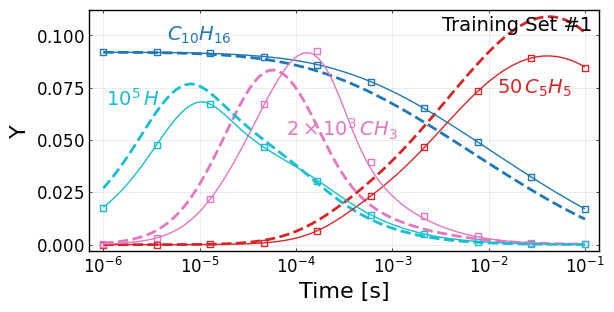

In [40]:
i_exp = 1 # n_exp_train + 5
i_epoch = 100
u0 = u0_list[i_exp,:]
y_init = y_init_list[i_exp,:,:]
y_true = y_true_list[i_exp,:,:]
_prob = remake(prob, u0=u0, p=history_p[i_epoch,:], tspan=tspan)
y_pred = solve(_prob, solver, saveat=tdense, sensalg=sensealg,
            reltol=reltol, abstol=abstol, verbose=false)
h1 = plot_species(tsteps, y_true, tdense, y_init, y_pred, :log10;
    xypos=[[1e-5, 0.1], [3e-2, 0.075], [3e-4, 0.055], [2e-6, 0.07]])
annotate!(h1, 1.2e-1, 0.105, Plots.text("Training Set #1", :right))
Plots.savefig(h1, "figures/JP10sk_compare_Yselect_i_exp=$(i_exp)_allsp.svg")

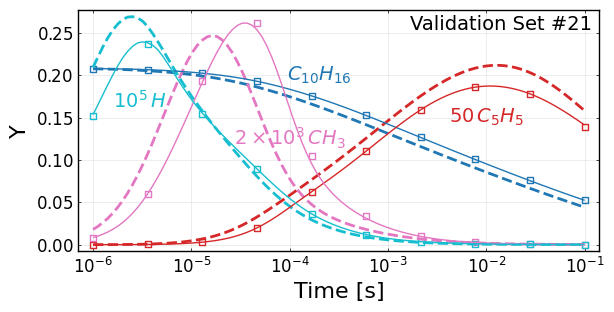

In [41]:
i_exp = 21 # n_exp_train + 5
i_epoch = 100
u0 = u0_list[i_exp,:]
y_init = y_init_list[i_exp,:,:]
y_true = y_true_list[i_exp,:,:]
_prob = remake(prob, u0=u0, p=history_p[i_epoch,:], tspan=tspan)
y_pred = solve(_prob, solver, saveat=tdense, sensalg=sensealg,
            reltol=reltol, abstol=abstol, verbose=false)
h2 = plot_species(tsteps, y_true, tdense, y_init, y_pred, :log10;
    xypos=[[2e-4, 0.2], [1e-2, 0.15], [1e-4, 0.125], [3e-6, 0.17]])
annotate!(h2, 1.2e-1, 0.26, Plots.text("Validation Set #21", :right))
Plots.savefig(h2, "figures/JP10sk_compare_Yselect_i_exp=$(i_exp)_allsp.svg")

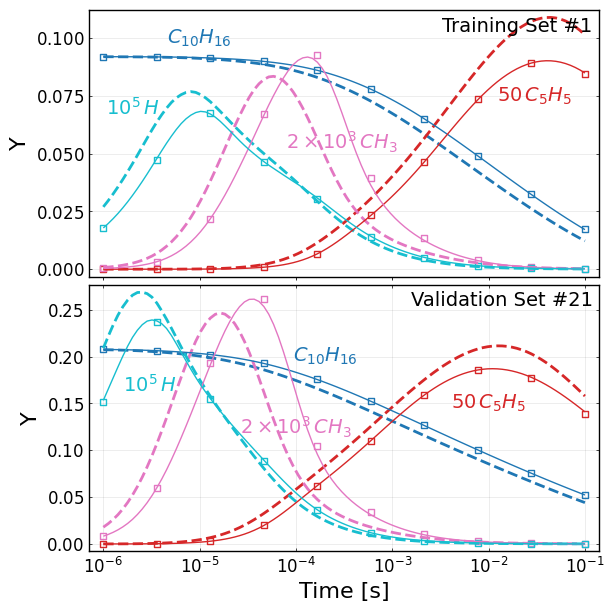

In [42]:
plot!(h1, xticks=[], xlabel="")
h = plot(h1, h2, layout=(2,1), size=(600,600))
Plots.savefig(h, "figures/JP10sk_compare_Yselect_combine_allsp.svg")

In [43]:
grad_all = Array([ForwardDiff.gradient( x -> loss_ode(x, i; abstol=abstol), p_init) for i in 1:20]);

In [44]:
# grad_nominal = ForwardDiff.gradient( x -> loss_ode(x, 1; abstol=abstol), p_init);
# grad_nominal = Array(mean([abs.(grad_i) for grad_i in grad_all], dims=1))[1];
# grad_nominal = ForwardDiff.gradient( x -> loss_ode(x, 1; abstol=abstol), p_init);
grad_nominal = ForwardDiff.gradient(fsol, p_true)';

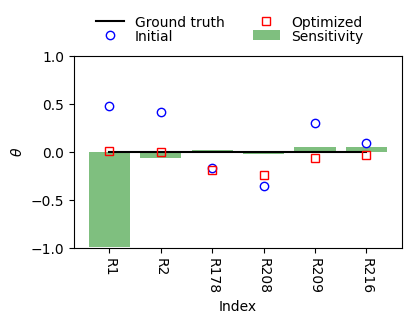

length(p_indexs) = 6


In [45]:
p_indexs = Vector{Int64}();
p_change = Vector{Float64}();

grad = grad_nominal
# grad = sqrt.(sqrt.(abs.(grad_nominal))).* sign.(grad_nominal)
sens = grad / norm(grad)

xticks = Vector{String}();
plot(p_pred - p_init)
for i in 1:nr
    # if (p_pred[i]-p_init[i])/(0-p_init[i]) > 0.5
    if abs(sens[i]) > 0.01 # && abs(p_pred[i]) - abs(p_init[i]) < - 0.05
        push!(p_indexs, i)
        push!(xticks, "R$i")
    end
end
n = length(p_indexs)
@show length(p_indexs)

fig = PyPlot.figure(figsize=(4, 3))
x = float.(1:n);
# x = p_indexs;
ha = PyPlot.plot(x, x .* 0, "k-", label="Ground truth")
hc = PyPlot.bar(x, sens[p_indexs], width=0.8, color="g", alpha=0.5, label="Sensitivity")
hb = PyPlot.plot(x, (p_init[p_indexs]), "o", color="b", fillstyle="none", label="Initial")
hd = PyPlot.plot(x, (p_pred[p_indexs]), "s", color="r", fillstyle="none", label="Optimized")
PyPlot.xlabel("Index")
PyPlot.ylabel(L"$\theta$")
PyPlot.ylim([-1,1])
PyPlot.xticks(x, xticks, rotation=270)
fig.subplots_adjust(left=0.16, right=0.98, hspace=0.42, top=0.85, bottom=0.21)
fig.legend(#labels=["a", "v", "c", "d"],
            #bbox_to_anchor=(0.82,0.5), loc="center left", ncol=1)
            bbox_to_anchor=(0.55,0.85), loc="lower center", ncol=2, labelspacing=0.02, frameon=false)
fig.savefig("figures/JP10sk_p_update_sens_allsp.svg")

In [46]:
grad_nominal = ForwardDiff.gradient(x -> loss_ode(x, 1; abstol=1e-9), p_init)'

1×232 Adjoint{Float64,Array{Float64,1}}:
 0.0276575  0.03898  -0.000450085  4.86268e-20  …  -0.000587754  -0.0102166

In [47]:
# grad_nominal = ForwardDiff.gradient(x -> loss_ode(x, 21; abstol=1e-9), p_init)'

In [48]:
# grad_nominal = ForwardDiff.gradient(x -> predict_ode(u0_list[21,:], x)[end,end], p_init)'

In [49]:
for i in 1:n_exp
    @printf "%.4f %.0f\r\n" u0_list[i, species_index(gas, "C10H16")] u0_list[i,end]
end

0.0920 1192
0.1064 1104
0.1640 1080
0.1928 1048
0.1496 1184
0.0272 1088
0.1208 1096
0.0560 1136
0.1784 1176
0.0848 1168
0.0992 1072
0.1352 1040
0.1856 1064
0.0632 1032
0.1424 1152
0.1568 1024
0.0776 1128
0.1280 1008
0.1136 1016
0.0416 1112
0.2080 1256
0.3000 1320
0.2160 1360
0.2840 1400
0.2280 1344
